In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

┌ Info: Recompiling stale cache file /usr/people/briandd/.julia/compiled/v1.2/pulse_input_DDM/m8WoA.ji for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1240
  ** incremental compilation may be fatally broken for this module **



In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [5]:
region, rat = "FOF", "T063"

("FOF", "T063")

In [6]:
sessions = filter(x->occursin(rat,x), readdir(path))

17-element Array{String,1}:
 "T063_191956.mat"
 "T063_193936.mat"
 "T063_194554.mat"
 "T063_194649.mat"
 "T063_194770.mat"
 "T063_194898.mat"
 "T063_195271.mat"
 "T063_195546.mat"
 "T063_195676.mat"
 "T063_195791.mat"
 "T063_196336.mat"
 "T063_196580.mat"
 "T063_196708.mat"
 "T063_197075.mat"
 "T063_197212.mat"
 "T063_197479.mat"
 "T063_198004.mat"

In [7]:
output = load.(joinpath.(path, sessions[end-1:end]), true, delay=0.0);

In [8]:
data = getindex.(output, 1)
μ_rnt = getindex.(output, 2);
μ_t = getindex.(output, 3);

In [9]:
data = vcat(data...)
μ_rnt = vcat(μ_rnt...)
μ_t = vcat(μ_t...);

In [10]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [1, 1, 1, 1], [319, 309, 309, 309], 4)

In [11]:
nconds, dt = 2, 1e-2

(2, 0.01)

In [12]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [13]:
using PyPlot

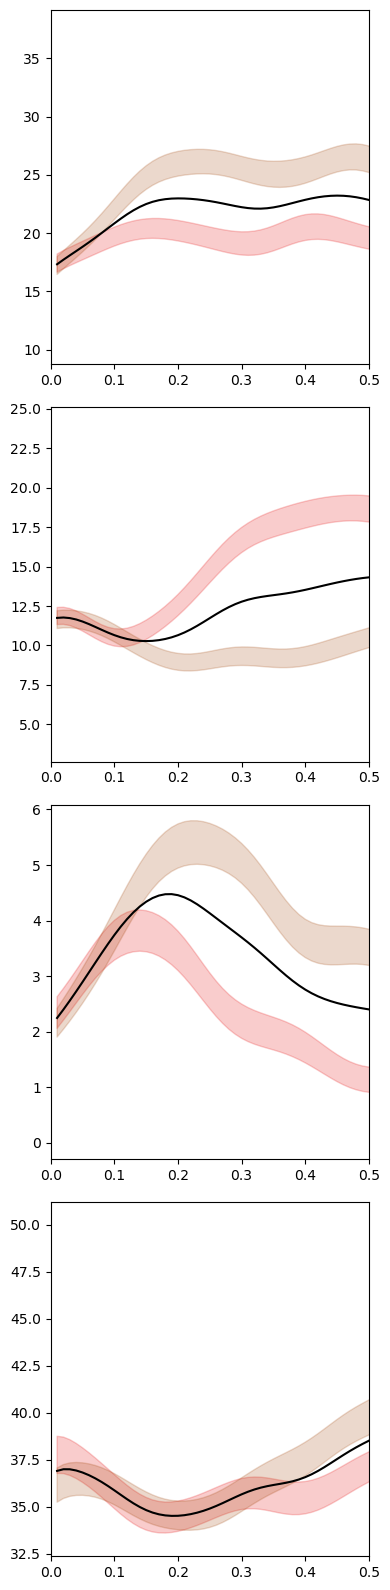

In [14]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

## Fit

In [15]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [16]:
options0 = neuraloptions(ncells=ncells,
    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0))

neuraloptions
  ncells: Array{Int64}((4,)) [1, 1, 1, 1]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((23,)) Bool[0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((23,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, -100.0, 0.0, -10.0  …  -10.0, -10.0, -100.0, 0.0, -10.0, -10.0, -100.0, 0.0, -10.0, -10.0]
  ub: Array{Float64}((23,)) [30.0, 32.0, 5.0, 200.0, 5.0, 1.2, 1.0, 100.0, 100.0, 10.0  …  10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 100.0, 100.0, 10.0, 10.0]
  x0: Array{Float64}((23,)) [0.0, 30.0, 2.220446049250313e-16, 0.0, 0.0, 0.9999999999999998, 0.008, 12.777777777777777, 11.84635875208813, 0.0014742132226192811  …  -0.002245340779347089, 0.0, 0.1, 3.9404951169657054, 0.0005687069143647916, 0.0, 36.29113575946466, 9.71525401689317, 0.001225733958446602, 0.0]


In [17]:
model, = optimize(data, options0; show_trace=false)

optimization complete. converged: true 



(neuralDDM{θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}},Array{Any,1}}
  θ: θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  data: Array{Any}((4,))
,  * Status: success

 * Candidate solution
    Minimizer: [-5.71e-01, 5.12e+01, -3.03e-03,  ...]
    Minimum:   4.914817e+04

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [1.28e+01, 1.18e+01, 1.47e-03,  ...]

 * Convergence measures
    |x - x'|               = 1.43e-02 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.59e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.56e-03 ≰ 1.0e-06
    |f(x) - f(x')|/|f(x')| = 5.21e-08 ≰ 0.0e+00
    |g(x)|                 = 5.16e-01 ≰ 1.0e-03

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    2
    f(x) calls:    138
    ∇f(x) calls:   79
)

In [18]:
model.θ.θy

4-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -0.5714134433493123
  b: Float64 51.19798869016755
  c: Float64 -0.0030314490646050603
  d: Float64 -4.415478762847468
]
 [Sigmoid{Float64}
  a: Float64 0.045778032605305816
  b: Float64 31.71879250574676
  c: Float64 0.004617113455684711
  d: Float64 -6.985930582005746
] 
 [Sigmoid{Float64}
  a: Float64 -19.76827087067145
  b: Float64 19.738275873172025
  c: Float64 -0.0011694443828046076
  d: Float64 6.387400831774876
] 
 [Sigmoid{Float64}
  a: Float64 -0.927968420950598
  b: Float64 59.410785528332816
  c: Float64 -0.0025204993336522606
  d: Float64 -4.198165957249916
]

In [19]:
fit=vcat(falses(1), trues(dimz-1), trues(sum(ncells)*nparams))
#x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0);
x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], pulse_input_DDM.flatten(model.θ)[dimz+1:end]);

In [20]:
options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f);

In [21]:
n = 53

53

In [22]:
model, = optimize(data, options, n);

Fminbox
-------
Initial mu = 0.000714029

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000714029

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     4.914878e+04     1.303502e+02
 * time: 2.6226043701171875e-5
     1     4.913998e+04     3.961873e+02
 * time: 6.6830360889434814
     2     4.913609e+04     3.259803e+02
 * time: 14.819805145263672
     3     4.913190e+04     4.081335e+01
 * time: 18.09729313850403
     4     4.913041e+04     3.979601e+01
 * time: 22.868277072906494
     5     4.912524e+04     7.310440e+01
 * time: 26.199069023132324
     6     4.912185e+04     4.463965e+02
 * time: 29.524668216705322
     7     4.911449e+04     7.524110e+02
 * time: 34.299745082855225
     8     4.911422e+04     8.643738e+02
 * time: 40.623271226882935
     9     4.911099e+04     7.909906e+02
 * time: 45.570197105407715
    10     4.910981e+04     8.469923e+02
 * time: 52.21338105201721
    11     4.910531e+04  

   117     4.883738e+04     1.059017e+01
 * time: 448.6439781188965
   118     4.883727e+04     1.405613e+01
 * time: 451.78929805755615
   119     4.883702e+04     1.323457e+01
 * time: 455.00131011009216
   120     4.883663e+04     1.556897e+01
 * time: 458.14692306518555
   121     4.883625e+04     1.688154e+01
 * time: 461.32293605804443
   122     4.883606e+04     2.979739e+01
 * time: 464.4785740375519
   123     4.883572e+04     1.333213e+01
 * time: 467.6235680580139
   124     4.883557e+04     2.321181e+01
 * time: 470.79210901260376
   125     4.883530e+04     3.965581e+01
 * time: 473.94299602508545
   126     4.883501e+04     2.797862e+01
 * time: 478.66139006614685
   127     4.883455e+04     2.374183e+01
 * time: 482.0242850780487
   128     4.883434e+04     2.164898e+01
 * time: 485.23032212257385
   129     4.883394e+04     2.030478e+01
 * time: 488.63716316223145
   130     4.883334e+04     4.401578e+01
 * time: 491.79552721977234
   131     4.883307e+04     3.421770e+

   238     4.883016e+04     7.424960e+00
 * time: 854.5833780765533
   239     4.883015e+04     3.850550e+00
 * time: 857.7381491661072
   240     4.883015e+04     2.211983e+00
 * time: 860.9083781242371
   241     4.883014e+04     4.067757e+00
 * time: 864.0834410190582
   242     4.883013e+04     3.554281e+00
 * time: 867.271430015564
   243     4.883012e+04     2.049270e+00
 * time: 870.4204030036926
   244     4.883011e+04     2.402539e+00
 * time: 875.1824910640717
   245     4.883011e+04     2.575913e+00
 * time: 878.340832233429
   246     4.883010e+04     1.066529e+00
 * time: 881.491464138031
   247     4.883010e+04     1.177989e+00
 * time: 884.6535851955414
   248     4.883010e+04     1.305356e+00
 * time: 887.8066291809082
   249     4.883010e+04     1.313791e+00
 * time: 891.0414640903473
   250     4.883010e+04     1.330557e+00
 * time: 894.2073681354523
   251     4.883010e+04     1.343003e+00
 * time: 897.3587820529938

Exiting inner optimizer with x = [30.1931258489054

In [23]:
model.θ.θz

θz{Float64}
  σ2_i: Float64 0.1
  B: Float64 30.193126358058205
  λ: Float64 -0.6143882243285739
  σ2_a: Float64 15.411318621672242
  σ2_s: Float64 2.255433297287149
  ϕ: Float64 0.8762858121323059
  τ_ϕ: Float64 0.9999998328748073


In [24]:
model.θ.θy

4-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -12.217304952707309
  b: Float64 45.711569103706786
  c: Float64 0.14481885236153444
  d: Float64 -1.1815477265603462
]
 [Sigmoid{Float64}
  a: Float64 -13.3648146503992
  b: Float64 22.134326846514835
  c: Float64 -0.16462943601318825
  d: Float64 0.40493022957147007
] 
 [Sigmoid{Float64}
  a: Float64 -5.056415653178212
  b: Float64 6.666492584514143
  c: Float64 0.3839420648500818
  d: Float64 1.9223418203387608
]    
 [Sigmoid{Float64}
  a: Float64 -3.168024974056149
  b: Float64 19.453285967753736
  c: Float64 0.18903345545302863
  d: Float64 -1.8941902573061884
] 

## Sample rates

In [25]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=nconds);

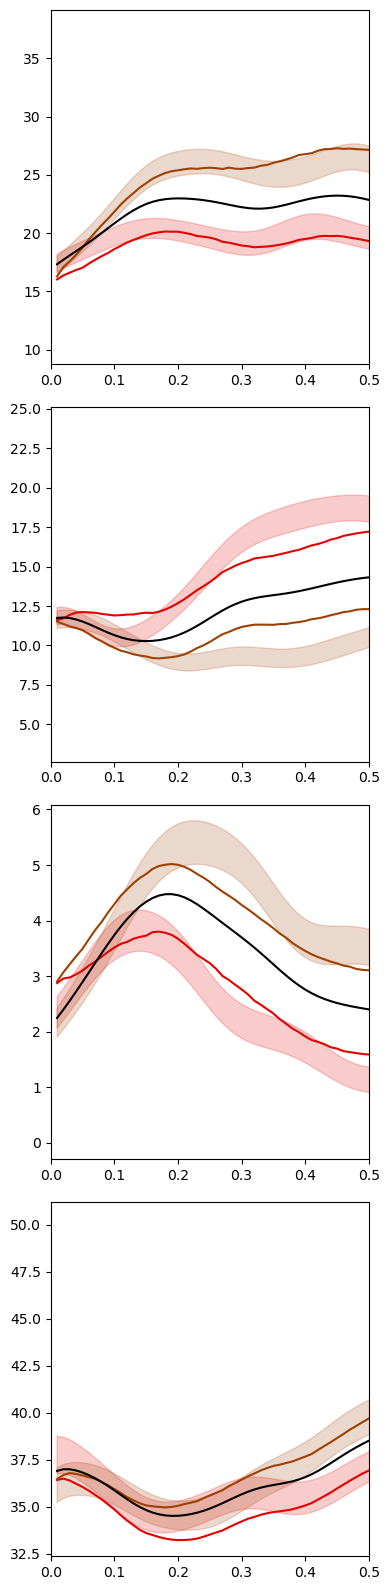

In [26]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax.plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])  
                
                ax[j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

## Model fit

In [35]:
LL_ML = loglikelihood(model.θ, data, n)

-48830.177044935685

In [36]:
LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
        +, 1:data.ncells), +, data), +, data, model.θ.θy)

-49190.77175874924

In [37]:
LL_ML - LL_null

360.5947138135525

In [30]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

SSx (generic function with 1 method)

In [31]:
1 - SSx(μ_c_λ - μ_ct, 40)/SSx(μ_ct, 40)

0.9983149146652326

### Compute Hessian
Blah blah blah

In [32]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

In [33]:
CI

23-element Array{Float64,1}:
  1.7770788262367472 
 59.25619195702598   
  0.5977221183827091 
 82.19122474799613   
  2.549875042554903  
  0.05344683045582445
  0.5427801487797582 
  6.230743678933208  
 50.698337988314144  
  0.1374221184074568 
  0.9400301670233494 
  7.80176993300368   
 13.075882727296781  
  0.14419488478283152
  0.5798580048029136 
  7.318498010786199  
  7.8156678769256205 
  0.6028129274347451 
  1.698767853334798  
  4.794103459997308  
 35.84481992658154   
  0.36963518599625184
  1.9134455403800545 

In [38]:
pulse_input_DDM.flatten(model.θ)

23-element Array{Float64,1}:
   0.1                
  30.193126358058205  
  -0.6143882243285739 
  15.411318621672242  
   2.255433297287149  
   0.8762858121323059 
   0.9999998328748073 
 -12.217304952707309  
  45.711569103706786  
   0.14481885236153444
  -1.1815477265603462 
 -13.3648146503992    
  22.134326846514835  
  -0.16462943601318825
   0.40493022957147007
  -5.056415653178212  
   6.666492584514143  
   0.3839420648500818 
   1.9223418203387608 
  -3.168024974056149  
  19.453285967753736  
   0.18903345545302863
  -1.8941902573061884 